# Final Project -- Reddit News Data vs. Dow Jones Market Performance
## By: Oliver Hamilton, Tim O'Brien, and Gabriel Ting
---

### Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

The combined dataset below contains dates along with corresponding labels indicating market upward (1) or downward (0) trend and the day's top 25 Reddit news story headlines from the morning before market open. 

The DOW dataset below is used to extract the exact magnitude of upward or downward market movement for the days on which we have sampled reddit news data.

In [2]:
combined_dataset = pd.read_csv('./data/Combined_News_DJIA.csv')
combined_dataset = combined_dataset.drop(columns = ["Label"])  # We do not care about this binary upward/downward indicator...it is too weak

dow_dataset = pd.read_csv('./data/upload_DJIA_table.csv')
dow_dataset = dow_dataset[::-1]  # Reverse columns

### Data Transformation and Visualization

In [3]:
dow_dataset.head()

,Date,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In the cell below, we transform the "Open" and "Close" columns across all our market days to form a percentage change column that will be added to our original combined dataset. Similarly, we will add a spread measure too. This will be represented as the high price minus the low price relative to the opening price of the index for the day.

In [4]:
# This function cleans off all 'b's, blank characters, and leading " or ' characters from the news article headers.
def clean_header(header):
    i, j = 0, len(header) - 1
    while header[i] in """b'" """:  # Iterable with: 'b', ' ', ", and '.
        i += 1
    while header[j] in """'" """:  # Iterable with: ', ", and ' '.
        j -= 1
    return header[i:j+1]

In [5]:
combined_dataset = combined_dataset.applymap(lambda x: clean_header(str(x)))

magnitude_labels = (dow_dataset["Close"] - dow_dataset["Open"]) / dow_dataset["Open"]  # Percent change measure
combined_dataset.insert(1, "percent_change", magnitude_labels.tolist())

spread_labels = (dow_dataset["High"] - dow_dataset["Low"]) / dow_dataset["Open"]  # Spread measure
combined_dataset.insert(2, "spread_rel_open", spread_labels.tolist())

print("Dataset has shape: " + str(combined_dataset.shape))
combined_dataset.head()

Dataset has shape: (1989, 28)


,Date,percent_change,spread_rel_open,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0.026437,0.032533,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.,Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Ossetia,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge
1,2008-08-11,0.004491,0.016333,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict,Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,...,Israel and the US behind the Georgian aggression?,"Do not believe TV, neither Russian nor Georgia...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer,War in South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over ...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war,So this is what it's come to: trading sex for ...
2,2008-08-12,-0.011818,0.015348,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation,If we had no sexual harassment we would have n...,Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right,"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?,BBC NEWS | Asia-Pacific | Extinction 'by man n...
3,2008-08-13,-0.008583,0.015511,U.S. refuses Israel weapons to attack Iran: re...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters cameraman,"Britain\'s policy of being tough on drugs is ""...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,Bush announces Operation Get All Up In Russia'...,...,Elephants extinct by 2020?,US humanitarian missions soon in Georgia - if ...,Georgia's DDOS came from US sources,"Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice,Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: poll,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...
4,2008-08-14,0.007272,0.023187,All the experts admit that we should legalise ...,War in South Osetia - 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random House's Refusal to Pub...,Poland and US agree to missle defense deal. In...,...,Bank analyst forecast Georgian crisis 2 days e...,Georgia confict could set back Russia's US rel...,War in the Caucasus is as much the product of ...,"Non-me

Now, the goal is to create rich embeddings to represent the textual Reddit news story data in attempt to cluster similar news story headings, compare their sentiment, and hopefully develop a strong classifier for one of the metrics above. Below, we import the dataset with the news header embeddings and add the percent_change and the spread_rel_open metrics.

In [6]:
embeddings_dataset = pd.read_csv('./data/embeddings_dataset.csv')
embeddings_dataset.insert(1, "percent_change", magnitude_labels.tolist())
embeddings_dataset.insert(2, "spread_rel_open", spread_labels.tolist())
embeddings_dataset.head()

,Date,percent_change,spread_rel_open,Top1_feature_0,Top1_feature_1,Top1_feature_2,Top1_feature_3,Top1_feature_4,Top1_feature_5,Top1_feature_6,...,Top10_feature_502,Top10_feature_503,Top10_feature_504,Top10_feature_505,Top10_feature_506,Top10_feature_507,Top10_feature_508,Top10_feature_509,Top10_feature_510,Top10_feature_511
0,2008-08-08,0.026437,0.032533,0.045079,-0.022705,-0.054172,0.004627,-0.072887,0.006421,-0.013796,...,0.037529,0.079555,0.007900,0.052349,-0.032850,-0.024886,-0.008362,-0.008685,-0.037892,-0.041780
1,2008-08-11,0.004491,0.016333,0.019073,-0.077482,-0.030234,-0.024577,-0.029507,0.055582,-0.009761,...,0.035775,0.010439,0.047468,0.081217,-0.042919,0.047936,-0.039455,-0.068909,-0.049422,-0.051906
2,2008-08-12,-0.011818,0.015348,0.016142,0.059271,0.054074,-0.040012,-0.067032,0.061725,-0.013906,...,0.016392,0.075807,-0.016552,0.010285,0.000613,-0.035458,-0.051954,-0.010246,-0.074031,-0.072625
3,2008-08-13,-0.008583,0.015511,-0.032401,-0.064624,0.020649,0.005840,0.006389,0.054969,0.016002,...,0.037088,0.064971,0.013768,0.051682,-0.050720,0.031203,0.008062,-0.045218,-0.021317,-0.054575
4,2008-08-14,0.007272,0.023187,0.022485,-0.027689,0.041283,0.037246,0.039393,0.002239,0.049105,...,0.048365,0.055074,0.078453,0.032827,-0.036714,0.023838,0.047548,0.054426,-0.072552,-0.024525


To display the relationships between headlines in the news, we slice the tranformed dataset by only considering the TOP Reddit news story each day. Then, graphs displaying the cosine similarity metric below for the first number_days (starting 08-08-2008) can be referenced below.

In [7]:
def plot_similarity(features, rotation):
    metric = cosine_similarity(features, features)
    sns.set(font_scale = 1.2)
    graph = sns.heatmap(metric, vmin = 0, vmax = 1)
    graph.set_title("Semantic Textual Cosine Similarity")

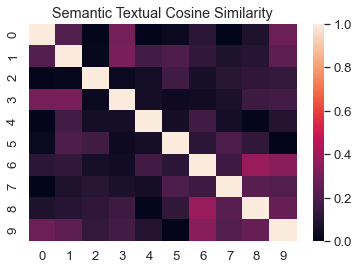

In [8]:
number_days = 10
plot_similarity(embeddings_dataset.loc[0 : number_days - 1, "Top1_feature_0" : "Top1_feature_511"], 90)

Lastly, lets take a peek at the top news headings for the following distinct pairings that have the highest indicated similarity between their embeddings: (0, 3), (1, 3), and (6, 8). We expext to see news headings that are semantically similar among these pairs.

In [9]:
print("Day 0 heading: " + combined_dataset["Top1"][0])
print("Day 3 heading: " + combined_dataset["Top1"][3])
sim = cosine_similarity(
    embeddings_dataset.loc[0 : 0, "Top1_feature_0" : "Top1_feature_511"], 
    embeddings_dataset.loc[3 : 3, "Top1_feature_0" : "Top1_feature_511"]
)
print("  --> cosine similarity = " + str(sim[0][0]) + "\n")

print("Day 1 heading: " + combined_dataset["Top1"][1])
print("Day 3 heading: " + combined_dataset["Top1"][3])
sim = cosine_similarity(
    embeddings_dataset.loc[1 : 1, "Top1_feature_0" : "Top1_feature_511"], 
    embeddings_dataset.loc[3 : 3, "Top1_feature_0" : "Top1_feature_511"]
)
print("  --> cosine similarity = " + str(sim[0][0]) + "\n")

print("Day 6 heading: " + combined_dataset["Top1"][6])
print("Day 8 heading: " + combined_dataset["Top1"][8])
sim = cosine_similarity(
    embeddings_dataset.loc[6 : 6, "Top1_feature_0" : "Top1_feature_511"], 
    embeddings_dataset.loc[8 : 8, "Top1_feature_0" : "Top1_feature_511"]
)
print("  --> cosine similarity = " + str(sim[0][0]) + "\n")

Day 0 heading: Georgia 'downs two Russian warplanes' as countries move to brink of war
Day 3 heading: U.S. refuses Israel weapons to attack Iran: report
  --> cosine similarity = 0.29798864249224893

Day 1 heading: Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?
Day 3 heading: U.S. refuses Israel weapons to attack Iran: report
  --> cosine similarity = 0.3074834316059009

Day 6 heading: In an Afghan prison, the majority of female prisoners are serving 20-year sentences for being victims of rape
Day 8 heading: Two elderly Chinese women have been sentenced to a year of re-education through labor after they sought a permit to demonstrate in an official Olympic protest area.
  --> cosine similarity = 0.38154694854352833



Here, in the above comparison, we can see that (0, 1, 3) are all about war, Isreal, Iraq/Iran. Additionally, we can see that (6, 8) both involve the topic of prison.

## In-Depth Data Investigation
In this section, we explore how different techniques and approaches may be utilized to extract insights.

In [11]:
from sklearn.cluster import KMeans
numClusters = 15
def getKMeansModel(data, K=numClusters):
    # Make the model and fit it to the data
    kMeansModel = KMeans(n_clusters=K)
    kMeansModel.fit(data)
    
    # Print the centroids
    centroids = kMeansModel.cluster_centers_
    
    return kMeansModel

In [12]:
# Predict which cluster the data falls into. Expects data to be a 2d array
from sklearn.metrics import silhouette_samples, silhouette_score

def predictCluster(model, data):
    return model.predict(data)
def silhouette(data, labels):
    return silhouette_score(data, labels)

In [17]:
# Grab all features excluding dates
allFeatures = embeddings_dataset.loc[:, "Top1_feature_0" : ]

# Convert to np array
allFeatures = allFeatures.to_numpy()

# Get the model
kMeansModel = getKMeansModel(allFeatures, 15)

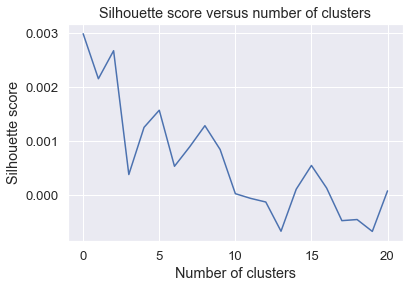

In [14]:
# Sample predictions of first ten inputs
import matplotlib.pyplot as plt
arr = []
for i in range(2, 23):
    kMeansModel = getKMeansModel(allFeatures, i)
    predict = (predictCluster(kMeansModel, allFeatures))
    arr.append(silhouette(allFeatures, predict))

plt.plot(arr)
plt.title("Silhouette score versus number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

In [19]:
# needs to be fixed


# # Print out some of the clusters
# predictions = predictCluster(kMeansModel, allFeatures[:100]),
# clusters = [[] for i in range(numClusters)]
# # Builds clusters
# for index, predict in enumerate(predictions):
#     clusters[index - 1].append(predict)
   

# print(clusters)
# for clusterIndex in range(len(clusters)):
#     print(clusterIndex)
#     for index in clusters[clusterIndex]:
#         print(combined_dataset["Top1"][index])

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [array([ 1,  6, 10, 10,  1, 10,  3, 14, 10, 10, 10,  2,  9, 10, 10, 10,  6,
        0, 10,  1,  6,  6, 14,  1,  1,  3, 14,  1,  6,  6, 14,  8,  6, 10,
       14,  4,  3,  9, 10, 14,  8,  0,  8,  7, 10, 12,  6,  6,  3,  1,  0,
        5, 14,  6,  9, 14,  6,  4,  9,  8, 14,  1, 13,  3, 12,  3,  7,  5,
       14,  3,  6,  5,  5,  9,  6,  9,  4,  3,  1,  4, 13,  3,  3,  2,  3,
        4,  9, 10,  9,  6,  0,  6, 14, 11,  9, 12,  4,  7,  7,  7])]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1     Why wont America and Nato help us? If they won...
6     In an Afghan prison, the majority of female pr...
10    Syria says its ready to put a Russian missile ...
10    Syria says its ready to put a Russian missile ...
1     Why wont America and Nato help us? If they won...
                            ...                        
12    North Korea halts denuclearisation after US fa...
4     All the experts admit that we should legalise ...
7     M

In [38]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sen = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\timot\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [83]:
# creates polarity scores for all news articles
flat_news = []
news_pol = [[] for i in range(10)]
for i in range(1, 11):
    accessStr = "Top" + str(i)
    topCur = []
    for headLine in combined_dataset[accessStr]:
        topCur.append(sen.polarity_scores(headLine))
        flat_news.append(headLine)
    compound = [x['neg'] for x in topCur]
    news_pol[i-1] = topCur

Average compound rating -0.2162445500251383
Calculated polarity {'neg': 0.0, 'neu': 0.572, 'pos': 0.428, 'compound': 0.9623} and compound 0.9623 for positive
Most positive article is 
 Snowden Nominated for Freedom of Thought Prize "Members of the European Parliament are officially nominating fugitive US leaker Edward Snowden for a prize celebrating freedom of thought, a parliamentary representative said Wednesday.
Calculated polarity {'neg': 0.465, 'neu': 0.51, 'pos': 0.025, 'compound': -0.9898} and compound -0.9898 for negative
Most negative article is 
 The war on drugs in Mexico, decreed by Caldern, part-funded by millions of dollars in U.S. govt aids, has not only failed to curb the trade but intensified horrific violence, corruption and human-rights abuses - 37,000 Mexicans have been murdered, often tortured and brutalized before their deaths


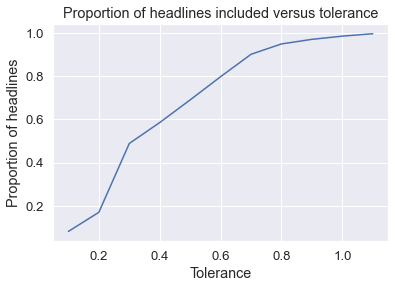

In [91]:
# calculate some statistics
flat_list = [x for top in news_pol for x in top]
neg_list = [x['neg'] for x in flat_list]
neu_list = [x['neu'] for x in flat_list]
pos_list = [x['pos'] for x in flat_list]
comp_list = [x['compound'] for x in flat_list]

avg_comp = np.average(comp_list)
print("Average compound rating {}".format(avg_comp))
max_ind = (np.argmax(comp_list))
min_ind = (np.argmin(comp_list))
print("Calculated polarity {} and compound {} for positive".format(sen.polarity_scores(flat_news[max_ind]), comp_list[max_ind]))
print("Most positive article is \n", flat_news[max_ind])
print("Calculated polarity {} and compound {} for negative".format(sen.polarity_scores(flat_news[min_ind]), comp_list[min_ind]))
print("Most negative article is \n", flat_news[min_ind])

threshholds = [.1 * i for i in range(1, 12)]
t_arr = []
for t in threshholds:
    lower, upper = avg_comp - t, avg_comp + t
    percentile = np.count_nonzero((lower < comp_list) & (comp_list < upper))/len(comp_list)
    t_arr.append(percentile)
plt.plot(threshholds, t_arr)
plt.title("Proportion of headlines included versus tolerance")
plt.xlabel("Tolerance")
plt.ylabel("Proportion of headlines")
plt.show()